In this homework you will understand the fine-tuning procedure and get acquainted with Huggingface Datasets library

In [1]:
#!pip install folium==0.2.1
#!pip install datasets
#!pip install transformers
#!pip install optuna

For our goals we will use [Datasets](https://huggingface.co/docs/datasets/) library and take `yahoo_answers_topics` dataset - the task of this dataset is to divide documents on 10 topic categories. More detiled information can be found on the dataset [page](https://huggingface.co/datasets/viewer/).


In [2]:
from datasets import load_dataset

In [3]:
dataset = load_dataset('yahoo_answers_topics',revision="master") # the result is a dataset dictionary of train and test splits in this case

Generating train split:   0%|          | 0/1400000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Dataset yahoo_answers_topics downloaded and prepared to /root/.cache/huggingface/datasets/yahoo_answers_topics/yahoo_answers_topics/1.0.0/0edb353eefe79d9245d7bd7cac5ae6af19530439da520d6dde1c206ee38f4439. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

# **Part 1: Fine-tuning the model** (15 points + 5 bonus)

In [4]:
from transformers import (ElectraTokenizer, ElectraForSequenceClassification,
                          get_scheduler, pipeline, ElectraForMaskedLM, ElectraModel,TrainingArguments, Trainer)

import torch
from torch.utils.data import DataLoader
from datasets import load_metric
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Fine-tuning procedure on the end task consists of adding additional layers on the top of the pre-trained model. The resulting model can be tuned fully (passing gradients through the all model) or partially.

**Task**: 
- load tokenizer and model
- look at the predictions of the model as-is before any fine-tuning


```
- Why don't you ask [MASK]?
- What is [MASK]
- Let's talk about [MASK] physics
```

- convert `best_answer` to the input tokens (supporting function for dataset is provided below) 

```
def tokenize_function(examples):
    return tokenizer(examples["best_answer"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
```

- define optimizer, sheduler (optional)
- fine-tune the model (write the training loop), plot the loss changes and measure results in terms of weighted F1 score
- get the masked word prediction (sample sentences above) on the fine-tuned model, why the results as they are and what should be done in order to change that (write down your answer)
- In case you will tune the training hyperparameters (and write down your results) you will get 5 bonus points.

**Tips**:
- The easiest way to get predictions is to use transformers `pipeline` function 
- Do not forget to set `num_labels` parameter, when initializing the model
- To convert data to batches use `DataLoader`
- Even the `small` version of Electra can be long to train, so you can take data sample (>= 5000 and set seed for reproducibility)
- You may want to try freezing (do not update the pretrained model weights) all the layers exept the ones for classification, in that case use:


```
for param in model.electra.parameters():
      param.requires_grad = False
```


In [5]:
MODEL_NAME = "google/electra-small-generator"
TOKENIZER_NAME = "google/electra-small-generator"

In [6]:
#load tokenizer and model 
model = ElectraForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels = 10)

tokenizer = ElectraTokenizer.from_pretrained(
    TOKENIZER_NAME, do_lower_case=True)   

Downloading:   0%|          | 0.00/662 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/51.7M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/electra-small-generator were not used when initializing ElectraForSequenceClassification: ['generator_predictions.dense.weight', 'generator_lm_head.bias', 'generator_predictions.LayerNorm.bias', 'generator_predictions.LayerNorm.weight', 'generator_predictions.dense.bias', 'generator_lm_head.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-generator and are newly initializ

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

In [ ]:
#look at the predictions of the model as-is before any fine-tuning
pipe = pipeline(model= "google/electra-small-generator")
pipe(["Why don't you ask [MASK]?", "What is [MASK]", "Let's talk about [MASK] physics"])

Downloading:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

[[{'score': 0.5342992544174194,
   'sequence': "why don't you ask me?",
   'token': 2033,
   'token_str': 'me'},
  {'score': 0.08196018636226654,
   'sequence': "why don't you ask questions?",
   'token': 3980,
   'token_str': 'questions'},
  {'score': 0.04395333677530289,
   'sequence': "why don't you ask them?",
   'token': 2068,
   'token_str': 'them'},
  {'score': 0.04017288610339165,
   'sequence': "why don't you ask why?",
   'token': 2339,
   'token_str': 'why'},
  {'score': 0.030024440959095955,
   'sequence': "why don't you ask yourself?",
   'token': 4426,
   'token_str': 'yourself'}],
 [{'score': 0.9262322783470154,
   'sequence': 'what is?',
   'token': 1029,
   'token_str': '?'},
  {'score': 0.05156780779361725,
   'sequence': 'what is.',
   'token': 1012,
   'token_str': '.'},
  {'score': 0.021510401740670204,
   'sequence': 'what is!',
   'token': 999,
   'token_str': '!'},
  {'score': 0.0001196492012240924,
   'sequence': 'what is -',
   'token': 1011,
   'token_str': '

In [7]:
dataset['train'] = dataset['train'].shuffle(seed=42).select(range(8000))
dataset['test'] = dataset['test'].shuffle(seed=42).select(range(2000))

In [8]:
#convert best_answer to the input tokens
def tokenize_function(examples):
    return tokenizer(examples["best_answer"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [ ]:
tokenized_datasets.set_format("torch")

In [9]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(8000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(2000))
small_train_dataset = small_train_dataset.remove_columns(['id', 'question_title', 'question_content', 'best_answer'])
small_train_dataset = small_train_dataset.rename_column("topic", "labels")
small_eval_dataset = small_eval_dataset.remove_columns(['id', 'question_title', 'question_content', 'best_answer'])
small_eval_dataset = small_eval_dataset.rename_column("topic", "labels")

In [ ]:
train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=8)

In [10]:
torch.cuda.empty_cache()

In [11]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_

In [ ]:
import numpy as np

In [ ]:
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=5e-5, weight_decay = 0.0001)
num_epochs = 12
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [ ]:
from tqdm.auto import tqdm
model.to(device)
progress_bar = tqdm(range(num_training_steps))
losses_epoch = []
for epoch in range(num_epochs):
    losses = []
    model.train()
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        losses.append(loss.detach())
    losses_epoch.append(sum(losses)/len(losses))
    print(f"Epoch {epoch}\n Current loss {sum(losses)/len(losses)}\n")

  0%|          | 0/12000 [00:00<?, ?it/s]

Epoch 0
 Current loss 1.633652925491333

Epoch 1
 Current loss 1.2297836542129517

Epoch 2
 Current loss 1.0680792331695557

Epoch 3
 Current loss 0.9031277298927307

Epoch 4
 Current loss 0.7525016069412231

Epoch 5
 Current loss 0.6543816328048706

Epoch 6
 Current loss 0.5210931301116943

Epoch 7
 Current loss 0.43278181552886963

Epoch 8
 Current loss 0.35538896918296814

Epoch 9
 Current loss 0.29564520716667175

Epoch 10
 Current loss 0.24615700542926788

Epoch 11
 Current loss 0.2248491644859314



In [ ]:
losses_epoch_list = [losses_epoch[i].cpu().detach().numpy().item() for  i in range(len(losses_epoch))]


Text(0, 0.5, 'average loss')

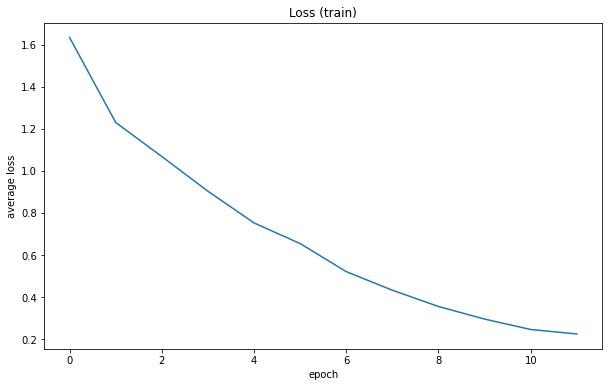

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(losses_epoch_list)
plt.title('Loss (train)')
plt.xlabel('epoch')
plt.ylabel('average loss')

In [ ]:
metric = load_metric('f1')
model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute(average = 'weighted')


{'f1': 0.5307663737422618}

In [ ]:
metric = load_metric('accuracy')
model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

{'accuracy': 0.535}

In [ ]:
model.save_pretrained('model_1')

In [ ]:
masked_model = ElectraForMaskedLM.from_pretrained('model_1', num_labels=10)


Some weights of the model checkpoint at model_1 were not used when initializing ElectraForMaskedLM: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
- This IS expected if you are initializing ElectraForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForMaskedLM were not initialized from the model checkpoint at model_1 and are newly initialized: ['generator_lm_head.bias', 'generator_predictions.dense.weight', 'generator_predictions.LayerNorm.bias', 'generator_predictions.dense.bias', 'generator_lm_head.weight', 'generator_predictions.LayerN

In [ ]:
#look at the predictions of the model as-is after fine-tuning
pipe = pipeline("fill-mask", model = masked_model, tokenizer = tokenizer, device = 0)



In [ ]:
pipe(["Why don't you ask [MASK]?", "What is [MASK]", "Let's talk about [MASK] physics"])

[[{'score': 0.0004578100924845785,
   'sequence': "why don't you askown?",
   'token': 12384,
   'token_str': '# # o w n'},
  {'score': 0.0003767804300878197,
   'sequence': "why don't you askmined?",
   'token': 25089,
   'token_str': '# # m i n e d'},
  {'score': 0.0003358901012688875,
   'sequence': "why don't you askborne?",
   'token': 19288,
   'token_str': '# # b o r n e'},
  {'score': 0.0003277803189121187,
   'sequence': "why don't you askience?",
   'token': 13684,
   'token_str': '# # i e n c e'},
  {'score': 0.0003087565419264138,
   'sequence': "why don't you askouin?",
   'token': 25058,
   'token_str': '# # o u i n'}],
 [{'score': 0.00047536074998788536,
   'sequence': 'what is humour',
   'token': 17211,
   'token_str': 'h u m o u r'},
  {'score': 0.000298694969387725,
   'sequence': 'what is korea',
   'token': 4420,
   'token_str': 'k o r e a'},
  {'score': 0.00029657810227945447,
   'sequence': 'what is korean',
   'token': 4759,
   'token_str': 'k o r e a n'},
  {'s

In [ ]:
model2 = ElectraForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels = 10)

In [ ]:
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=8e-5, weight_decay = 0.0001)
num_epochs = 15
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [ ]:
from tqdm.auto import tqdm
model.to(device)
progress_bar = tqdm(range(num_training_steps))
losses_epoch = []
for epoch in range(num_epochs):
    losses = []
    model.train()
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        losses.append(loss.detach())
    losses_epoch.append(sum(losses)/len(losses))
    print(f"Epoch {epoch}\n Current loss {sum(losses)/len(losses)}\n")

  0%|          | 0/15000 [00:00<?, ?it/s]

Epoch 0
 Current loss 1.1164151430130005

Epoch 1
 Current loss 0.9334055781364441

Epoch 2
 Current loss 0.7469808459281921

Epoch 3
 Current loss 0.5677914023399353

Epoch 4
 Current loss 0.4196290075778961

Epoch 5
 Current loss 0.31538838148117065

Epoch 6
 Current loss 0.22833183407783508

Epoch 7
 Current loss 0.18985117971897125

Epoch 8
 Current loss 0.1388254463672638

Epoch 9
 Current loss 0.11734484136104584

Epoch 10
 Current loss 0.09387068450450897

Epoch 11
 Current loss 0.08391130715608597

Epoch 12
 Current loss 0.07263050228357315

Epoch 13
 Current loss 0.061931490898132324

Epoch 14
 Current loss 0.05972592532634735



In [ ]:
losses_epoch_list2 = [losses_epoch[i].cpu().detach().numpy().item() for  i in range(len(losses_epoch))]

Text(0, 0.5, 'average loss')

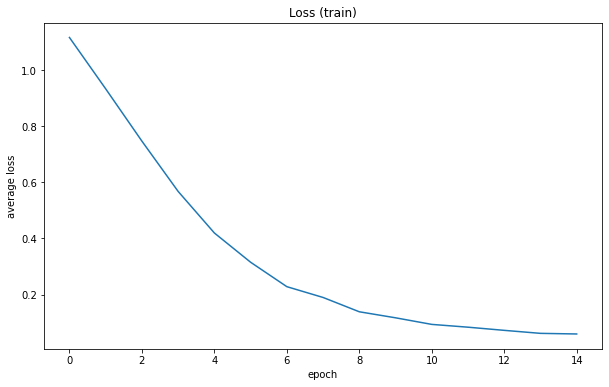

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(losses_epoch_list2)
plt.title('Loss (train)')
plt.xlabel('epoch')
plt.ylabel('average loss')

In [ ]:
metric = load_metric('f1')
model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute(average = 'weighted')

{'f1': 0.5383501715270327}

In [ ]:
metric = load_metric('accuracy')
model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

{'accuracy': 0.535}

In [ ]:
model.save_pretrained('model_2')

In [ ]:
masked_model = ElectraForMaskedLM.from_pretrained('model_2', num_labels=10)

Some weights of the model checkpoint at model_2 were not used when initializing ElectraForMaskedLM: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight']
- This IS expected if you are initializing ElectraForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForMaskedLM were not initialized from the model checkpoint at model_2 and are newly initialized: ['generator_lm_head.bias', 'generator_predictions.dense.weight', 'generator_predictions.LayerNorm.bias', 'generator_predictions.dense.bias', 'generator_lm_head.weight', 'generator_predictions.LayerN

In [ ]:
#look at the predictions of the model as-is after fine-tuning
pipe = pipeline("fill-mask", model = masked_model, tokenizer = tokenizer, device = 0)
pipe(["Why don't you ask [MASK]?", "What is [MASK]", "Let's talk about [MASK] physics"])

[[{'score': 0.00032228653435595334,
   'sequence': "why don't you ask interactive?",
   'token': 9123,
   'token_str': 'i n t e r a c t i v e'},
  {'score': 0.0002911246265284717,
   'sequence': "why don't you ask mermaid?",
   'token': 22322,
   'token_str': 'm e r m a i d'},
  {'score': 0.0002788607671391219,
   'sequence': "why don't you ask viruses?",
   'token': 18191,
   'token_str': 'v i r u s e s'},
  {'score': 0.00025869766250252724,
   'sequence': "why don't you ask adapted?",
   'token': 5967,
   'token_str': 'a d a p t e d'},
  {'score': 0.0002554479578975588,
   'sequence': "why don't you ask turtles?",
   'token': 16489,
   'token_str': 't u r t l e s'}],
 [{'score': 0.0002969129418488592,
   'sequence': 'what is fivb',
   'token': 28423,
   'token_str': 'f i v b'},
  {'score': 0.0002932320930995047,
   'sequence': 'what is overtime',
   'token': 12253,
   'token_str': 'o v e r t i m e'},
  {'score': 0.00028209504671394825,
   'sequence': 'what is cremated',
   'token': 2

In [ ]:
#Fine-tune hyperparameters
from torch.optim import AdamW, Adam

num_epochs = 5
opt_models = [AdamW]
learning_rates = [3e-5,0.0001]
weight_decay = [0, 0.01]
parameters = []    
for i in opt_models :        
    for j in learning_rates :   
      for k in weight_decay: 
            parameters.append( ( i, j, k) )

In [ ]:
num_epochs = 5
losses_all_parametrs_epoch = []
metric = load_metric('accuracy')
accuracy = []
from tqdm.auto import tqdm
for i, parameter in enumerate(parameters):
    model = ElectraForSequenceClassification.from_pretrained(MODEL_NAME, num_labels = 10)
    optimizer = parameter[0](model.parameters(), lr = parameter[1], weight_decay = parameter[2])
    num_training_steps = num_epochs * len(train_dataloader)
    lr_scheduler = get_scheduler( name="linear", optimizer=optimizer, num_warmup_steps=0, 
                                 num_training_steps=num_training_steps)
    model.to(device)
    losses_epoch = []
    progress_bar = tqdm(range(num_training_steps))
    print(f"Optimizer {parameter[0]},learning_rates = {parameter[1]},weight_decay = {parameter[2]} ")
    for epoch in range(num_epochs):
        losses = []
        model.train()
        for batch in train_dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)
            losses.append(loss.detach())
        losses_epoch.append(sum(losses)/len(losses))
        print(f"Epoch {epoch}\n Current loss {sum(losses)/len(losses)}\n")
    model.save_pretrained('model_'+str(i+10))
    losses_all_parametrs_epoch.append(losses_epoch)
    for batch in eval_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            metric.add_batch(predictions=predictions, references=batch["labels"])
    accuracy.append (metric.compute())

Some weights of the model checkpoint at google/electra-small-generator were not used when initializing ElectraForSequenceClassification: ['generator_predictions.dense.weight', 'generator_lm_head.weight', 'generator_predictions.dense.bias', 'generator_predictions.LayerNorm.weight', 'generator_predictions.LayerNorm.bias', 'generator_lm_head.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-generator and are newly initializ

  0%|          | 0/5000 [00:00<?, ?it/s]

Optimizer <class 'torch.optim.adamw.AdamW'>,learning_rates = 3e-05,weight_decay = 0 
Epoch 0
 Current loss 1.7166965007781982

Epoch 1
 Current loss 1.2487657070159912

Epoch 2
 Current loss 1.088849425315857

Epoch 3
 Current loss 0.9730929136276245

Epoch 4
 Current loss 0.8946314454078674



Some weights of the model checkpoint at google/electra-small-generator were not used when initializing ElectraForSequenceClassification: ['generator_predictions.dense.weight', 'generator_lm_head.weight', 'generator_predictions.dense.bias', 'generator_predictions.LayerNorm.weight', 'generator_predictions.LayerNorm.bias', 'generator_lm_head.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-generator and are newly initializ

  0%|          | 0/5000 [00:00<?, ?it/s]

Optimizer <class 'torch.optim.adamw.AdamW'>,learning_rates = 3e-05,weight_decay = 0.01 
Epoch 0
 Current loss 1.7127277851104736

Epoch 1
 Current loss 1.266711950302124

Epoch 2
 Current loss 1.1102321147918701

Epoch 3
 Current loss 0.9961583018302917

Epoch 4
 Current loss 0.919316291809082



Some weights of the model checkpoint at google/electra-small-generator were not used when initializing ElectraForSequenceClassification: ['generator_predictions.dense.weight', 'generator_lm_head.weight', 'generator_predictions.dense.bias', 'generator_predictions.LayerNorm.weight', 'generator_predictions.LayerNorm.bias', 'generator_lm_head.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-generator and are newly initializ

  0%|          | 0/5000 [00:00<?, ?it/s]

Optimizer <class 'torch.optim.adamw.AdamW'>,learning_rates = 0.0001,weight_decay = 0 
Epoch 0
 Current loss 1.572319746017456

Epoch 1
 Current loss 1.2111984491348267

Epoch 2
 Current loss 0.9996212124824524

Epoch 3
 Current loss 0.8073244690895081

Epoch 4
 Current loss 0.6439856290817261



Some weights of the model checkpoint at google/electra-small-generator were not used when initializing ElectraForSequenceClassification: ['generator_predictions.dense.weight', 'generator_lm_head.weight', 'generator_predictions.dense.bias', 'generator_predictions.LayerNorm.weight', 'generator_predictions.LayerNorm.bias', 'generator_lm_head.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-generator and are newly initializ

  0%|          | 0/5000 [00:00<?, ?it/s]

Optimizer <class 'torch.optim.adamw.AdamW'>,learning_rates = 0.0001,weight_decay = 0.01 
Epoch 0
 Current loss 1.6600314378738403

Epoch 1
 Current loss 1.2452948093414307

Epoch 2
 Current loss 1.01800537109375

Epoch 3
 Current loss 0.8169118762016296

Epoch 4
 Current loss 0.6605374813079834



In [ ]:
accuracy 

[{'accuracy': 0.57},
 {'accuracy': 0.571},
 {'accuracy': 0.5575},
 {'accuracy': 0.556}]

In [ ]:
#look at the predictions of the model as-is after fine-tuning
masked_model = ElectraForMaskedLM.from_pretrained('model_11', num_labels=10)
pipe3 = pipeline("fill-mask", model = masked_model, tokenizer = tokenizer, device = 0)
pipe3(["Why don't you ask [MASK]?", "What is [MASK]", "Let's talk about [MASK] physics"])

Some weights of the model checkpoint at model_11 were not used when initializing ElectraForMaskedLM: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
- This IS expected if you are initializing ElectraForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForMaskedLM were not initialized from the model checkpoint at model_11 and are newly initialized: ['generator_predictions.dense.weight', 'generator_lm_head.weight', 'generator_predictions.dense.bias', 'generator_predictions.LayerNorm.weight', 'generator_predictions.LayerNorm.bias', 'generator_

[[{'score': 0.0003114446299150586,
   'sequence': "why don't you askhya?",
   'token': 17915,
   'token_str': '# # h y a'},
  {'score': 0.00030656123999506235,
   'sequence': "why don't you ask italiana?",
   'token': 28059,
   'token_str': 'i t a l i a n a'},
  {'score': 0.00027647463139146566,
   'sequence': "why don't you ask ritter?",
   'token': 23168,
   'token_str': 'r i t t e r'},
  {'score': 0.00027399027021601796,
   'sequence': "why don't you ask versa?",
   'token': 18601,
   'token_str': 'v e r s a'},
  {'score': 0.0002738031034823507,
   'sequence': "why don't you ask chooses?",
   'token': 15867,
   'token_str': 'c h o o s e s'}],
 [{'score': 0.00048526894534006715,
   'sequence': 'what isgration',
   'token': 29397,
   'token_str': '# # g r a t i o n'},
  {'score': 0.0004314984835218638,
   'sequence': 'what is ying',
   'token': 20879,
   'token_str': 'y i n g'},
  {'score': 0.0003955316205974668,
   'sequence': 'what is augusto',
   'token': 29085,
   'token_str': 'a 

In this lab I have varied different parameters to fine-tune the model. I ran experiments on different number of epochs with different lr and weighted_decay. Initially, I ran experiments on a data size of 2000. These experiments showed worse results than on a larger data size.
The results of the mask sometimes show completely unexpected results. Perhaps this is due to the fact that we take a relatively small data size.
The best accuracy = 0.57 , f1 = 0.54

Also we can tunning hyperparameters and model using Trainer 

In [ ]:
#Tune the training hyperparameters using Trainer 
from tqdm.auto import tqdm
metric = load_metric('f1')

def compute_metrics(pred):
    predictions, label_ids = pred
    preds = np.argmax(predictions, axis=1)
    return metric.compute(
        predictions=preds, references=label_ids, average="weighted")
   

def model_init():
    model = ElectraForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=10, return_dict=True)
    return model.to(device)

training_args = TrainingArguments(
    output_dir="/content/drive/My Drive/",
    overwrite_output_dir=True,
    evaluation_strategy ="epoch",
    num_train_epochs = 5,
    per_device_train_batch_size=8,
    #load_best_model_at_end  = True,
    do_train = True,
    do_eval = True,
  
    )

trainer = Trainer(
    model_init = model_init,
    args = training_args,
    train_dataset = small_train_dataset, 
    eval_dataset = small_eval_dataset, 
    compute_metrics = compute_metrics,

)

# Defaut objective is the sum of all metrics when metrics are provided, so we have to maximize it.
trainer.hyperparameter_search(direction="maximize")

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/google/electra-small-generator/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/ddf7554779ef5bd660812cf3b6c92a66e14e307bae0f8582015b43ce8f8de85c.e50e2a54975f5ef36835643600664f71c63e7f570a08222c48829a8d8e327dca
Model config ElectraConfig {
  "architectures": [
    "ElectraForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "

In [ ]:
model

In [ ]:
1